參考[Keras深度學習神經網絡API](https://deeplizard.com/learn/video/OO4HD-1wRN8)、以及[老師的文件](https://github.com/ckhung/keras-mobilenet)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/colab_mango/keras-mobilenet')
os.listdir('.')

['README.md',
 'LICENSE',
 'mango_quiz',
 'mango_behaviors',
 'Untitled0.ipynb',
 'mango_behavior1120_1.h5',
 'mango_behavior30.h5',
 'mango_behavior18.h5',
 'mango_behavior14.h5',
 'km-transfer.ipynb']

載入相依套件 改成:https://deeplizard.com/learn/video/OO4HD-1wRN8

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.applications.mobilenet import preprocess_input
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

建立 MobileNet。 原始論文： [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications, Howard et al, 2017
](https://arxiv.org/pdf/1704.04861.pdf)


In [ ]:
mobile = keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
!ls -l /root/.keras/models
# 剛剛下載的權重矩陣放在這裡


total 16824
-rw-r--r-- 1 root root 17225924 Nov 12 16:28 mobilenet_1_0_224_tf.h5


In [ ]:
def prepare_image(image_path, show=True):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    if show:
        display(Image(filename=image_path))
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

def mobile_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = mobile.predict(prepared)
    return imagenet_utils.decode_predictions(ans)

先拿現成的類神經網路測試。 以下幾張圖片的狗狗所屬的品種都落在 [1000類標籤](https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json) 當中。 也可以改用 show=False 來阻止畫圖。 

In [ ]:
mobile_cl('mango_quiz/quiz1.jpg',show=False)  #改False

49152/35363 [=========================================] - 0s 0us/step


[[('n07747607', 'orange', 0.7808617),
  ('n07749582', 'lemon', 0.05814851),
  ('n03590841', "jack-o'-lantern", 0.04888612),
  ('n07768694', 'pomegranate', 0.021938898),
  ('n12620546', 'hip', 0.014240366)]]

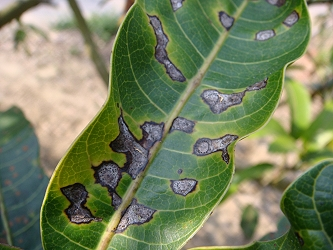

[[('n01693334', 'green_lizard', 0.29926682),
  ('n02231487', 'walking_stick', 0.2140198),
  ('n01729977', 'green_snake', 0.20996554),
  ('n01682714', 'American_chameleon', 0.07864395),
  ('n01644373', 'tree_frog', 0.043812003)]]

In [ ]:
from IPython.display import Image
mobile_cl('mango_quiz/quiz2.jpg',show=True)

以下要拿 MobileNet 來做遷移學習， 改訓練成芒果病蟲害的判斷。去除原本的輸出層 (top， 最下游那一層)、 替換成三層 fully connected layers， 以及含有19個 neurons 的新的輸出層。

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet  
base_model=MobileNet(weights='imagenet',include_top=False) 

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(19,activation='softmax')(x)  #更換成19種類別
mango_behavior = Model(inputs=base_model.input,outputs=preds)


17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
!ls -l /root/.keras/models # 這次下載的權重矩陣是 「無頂版」 (no_top)。

total 16824
-rw-r--r-- 1 root root 17225924 Dec  7 12:42 mobilenet_1_0_224_tf_no_top.h5


 畫圖的效果好像不太好， 會被截掉。 算了， 反正結構很單純， 還是直接印文字版好了：

In [ ]:
for i,layer in enumerate(mango_behavior.layers):
  print(i,layer.name)

鎖住上游大部分的權重(保留既有、訓練好的權重)，只訓練/改變最下游四層的權重。

In [ ]:
for layer in mango_behavior.layers:
    layer.trainable=False
for layer in mango_behavior.layers[-4:]:
    layer.trainable=True

把圖片目錄上傳到 drive 的 /colab/mango_behaviors/ 。

In [ ]:
!ls ./mango_behaviors/

 其他		'果實 炭疽病'   紅蜘蛛	       葉蟬		      藻斑病
 授粉不全	'果實 黑斑病'  '缺朋 缺鈣'    '葉部 炭疽病或黑斑病'   蟲茵
 果實成熟	 白龜神         葉子	      '蒂腐病 果實'	      鑽心蟲
'果實(未成熟)'	 紅斑炭疽病    '葉子 百粉病'   薊馬


把訓練圖片目錄 ./mango_behaviors/ 餵給 ImageDataGenerator：

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory(
    './mango_behaviors', target_size=(224,224), batch_size=32,
    class_mode='categorical', color_mode='rgb', shuffle=True
)
label2id = train_generator.class_indices
id2label = [label2id[x] for x in label2id]
id2label = dict((v,k) for k,v in label2id.items())

Found 1246 images belonging to 19 classes.


在 google colab 上用 GPU 訓練

In [ ]:
mango_behavior.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
mango_behavior.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    epochs=14
)

測試已訓練好的 mango_behavior 模型

In [ ]:
def behavior_cl(image_path, show=True):
    prepared = prepare_image(image_path, show)
    ans = mango_behavior.predict(prepared)[0]
    best = sorted(range(len(ans)), key=lambda k: -ans[k])[:1]
    return ['{:6.2f}% {}'.format(ans[id]*100,id2label[id]) for id in best]


測試相關圖片

In [ ]:
from glob import glob
for f in sorted(glob('mango_quiz/*.jpg')):
    print(f, behavior_cl(f,show=False))

In [ ]:
mango_behavior.save('./mango_behavior14.h5')

將訓練權重存檔

In [ ]:
!ls -trl . 